# What we have here?

We will evaluate the model, we will make the confusion matrix and we will see the accuracy of the model.

Note: As my computer is not very powerful, I used colab to train the model. You can use colab too, but you need to upload the dataset to your drive and change the path to the dataset.

### Installing and importing the libraries

In [1]:
!pip install pytorch-transformers==1.2.0 torch==1.10.1 torchaudio==0.10.1 torchtext==0.11.1 torchvision==0.11.2 transformers==4.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 7.9 MB/s 
     |██████████████████████████████▎ | 834.1 MB 60.5 MB/s eta 0:00:01tcmalloc: large alloc 1147494400 bytes == 0x3974c000 @  0x7fd65bffe615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 12 kB/s 
     |████████████████████████████████| 2.9 MB 35.1 MB/s 
     |████████████████████████████████| 8.0 MB 41.1 MB/s 
     |████████████████████████████████| 23.3 MB 56.9 MB/s 
     |████████████████████████████████| 3.3 MB 34.5 MB/s 
     |████████████████████████████████| 132 kB 67.0 MB/s 
     |████████████████████████████████| 880 kB 60.3 MB/s 
     |████████████████████

In [1]:
import pandas as pd

import torch
import torch.nn as nn

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('drive')

source_folder = 'drive/MyDrive/Colab-Notebooks/prueba-bert'
destination_folder = 'drive/MyDrive/Colab-Notebooks/prueba-bert'

Mounted at drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.json to test.json
Saving train.json to train.json
Saving valid.json to valid.json


### Tabular dataset and iterators

In [5]:
# tokenizer multilingual bert
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
#fields = [('label', label_field), ('titular', text_field), ('cuerpo', text_field), ('titletext', text_field)] # use this if data is csv
fields = {'label': ('label', label_field),
          'titular': ('titular', text_field),
          'cuerpo': ('cuerpo', text_field),
          'titletext': ('titletext', text_field)} # use this if data is json

# TabularDataset

train, valid, test = TabularDataset.splits(path="", train="train.json", validation="valid.json",
                                           test='test.json', format='json', fields=fields, skip_header=True)

# Iterators
batch_size = 8
test_iter = Iterator(test, batch_size=batch_size, device=device, train=False, shuffle=False, sort=False)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

### Functions for evaluation

In [6]:
def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

### Loss vs steps

Model loaded from <== drive/MyDrive/Colab-Notebooks/prueba-bert/metrics.pt


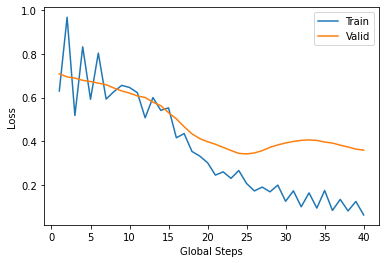

In [7]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')

plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

### Confusion matrix

In [8]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-multilingual-cased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [9]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Model loaded from <== drive/MyDrive/Colab-Notebooks/prueba-bert/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8000    1.0000    0.8889         4
           0     1.0000    0.8000    0.8889         5

    accuracy                         0.8889         9
   macro avg     0.9000    0.9000    0.8889         9
weighted avg     0.9111    0.8889    0.8889         9



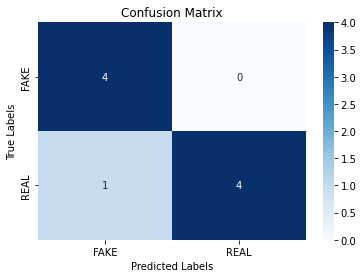

In [10]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)